In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import fault3d as f3
from matplotlib import ticker, cm
from pathlib import Path
import re
from geoist import gridder
config = {
    "font.family": 'Times New Roman',
    "font.size": 10,
}
plt.rcParams.update(config)

[Errno 17] File exists: '/public/home/liyongbo/.local/share/geoist'
[Errno 17] File exists: '/public/home/liyongbo/.local/share/geoist/examples'
[Errno 17] File exists: '/public/home/liyongbo/.local/share/geoist/temp'
[Errno 17] File exists: '/public/home/liyongbo/.local/share/geoist/data'


In [2]:
inp_file = "data/fault3d.inp"
log_file = "log.txt"

In [3]:
nx = 90
ny = 90
narea = tuple([-15, 15, -15, 15])
nshape = tuple([nx, ny])
outfile = f3.fault3d.fault(inp_file, log_file, nx, ny)
xp, yp, zp = gridder.regular(narea, nshape, z=0)

xp = np.array(xp)
yp = np.array(yp)
data = np.array(outfile).flatten()
from geoist.pfm import giutils
v = {
        'x' : list(yp),
        'y' : list(xp),
        'data' : data,}

x = xp.reshape(nx, ny)
y = yp.reshape(nx, ny)
da = data.reshape(nx, ny)

true_data = np.concatenate((da[:, 30],da[:, 55],da[50,:]))

field = giutils.contaminate(np.array(data), 0.05, percent = True, seed = 2022)
field = field.reshape(nx, ny)
obs_data = np.concatenate((field[:, 30],field[:, 55],field[50,:]))

In [4]:
def make_datafile(v, depth_bottom, dip, filename = 'f3d.dat'):
    with open(filename,'w') as f:
        f.write('1, 0\n')
        f.write('0.0, 0.0\n')
        f.write(str(v)+','+' 0.5,'+str(depth_bottom)+", 3.0")
        f.write(',6.0,L,')
        f.write(str(dip))
        f.write(',60,GL1,1.5,0.0\n')
        
def get_gravity(density_inv, depth_bottom, dip):
    make_datafile(density_inv, depth_bottom, dip)
    outfile = f3.fault3d.fault("f3d.inp", log_file, nx, ny)
    data = np.array(outfile).flatten()
    da = data.reshape(nx, ny)
    predict_data = np.concatenate((da[:, 30],da[:, 55],da[50, :]))
    os.remove("f3d.dat")
    return predict_data

gz_exp = get_gravity(0.505, 2.530, 151.446)

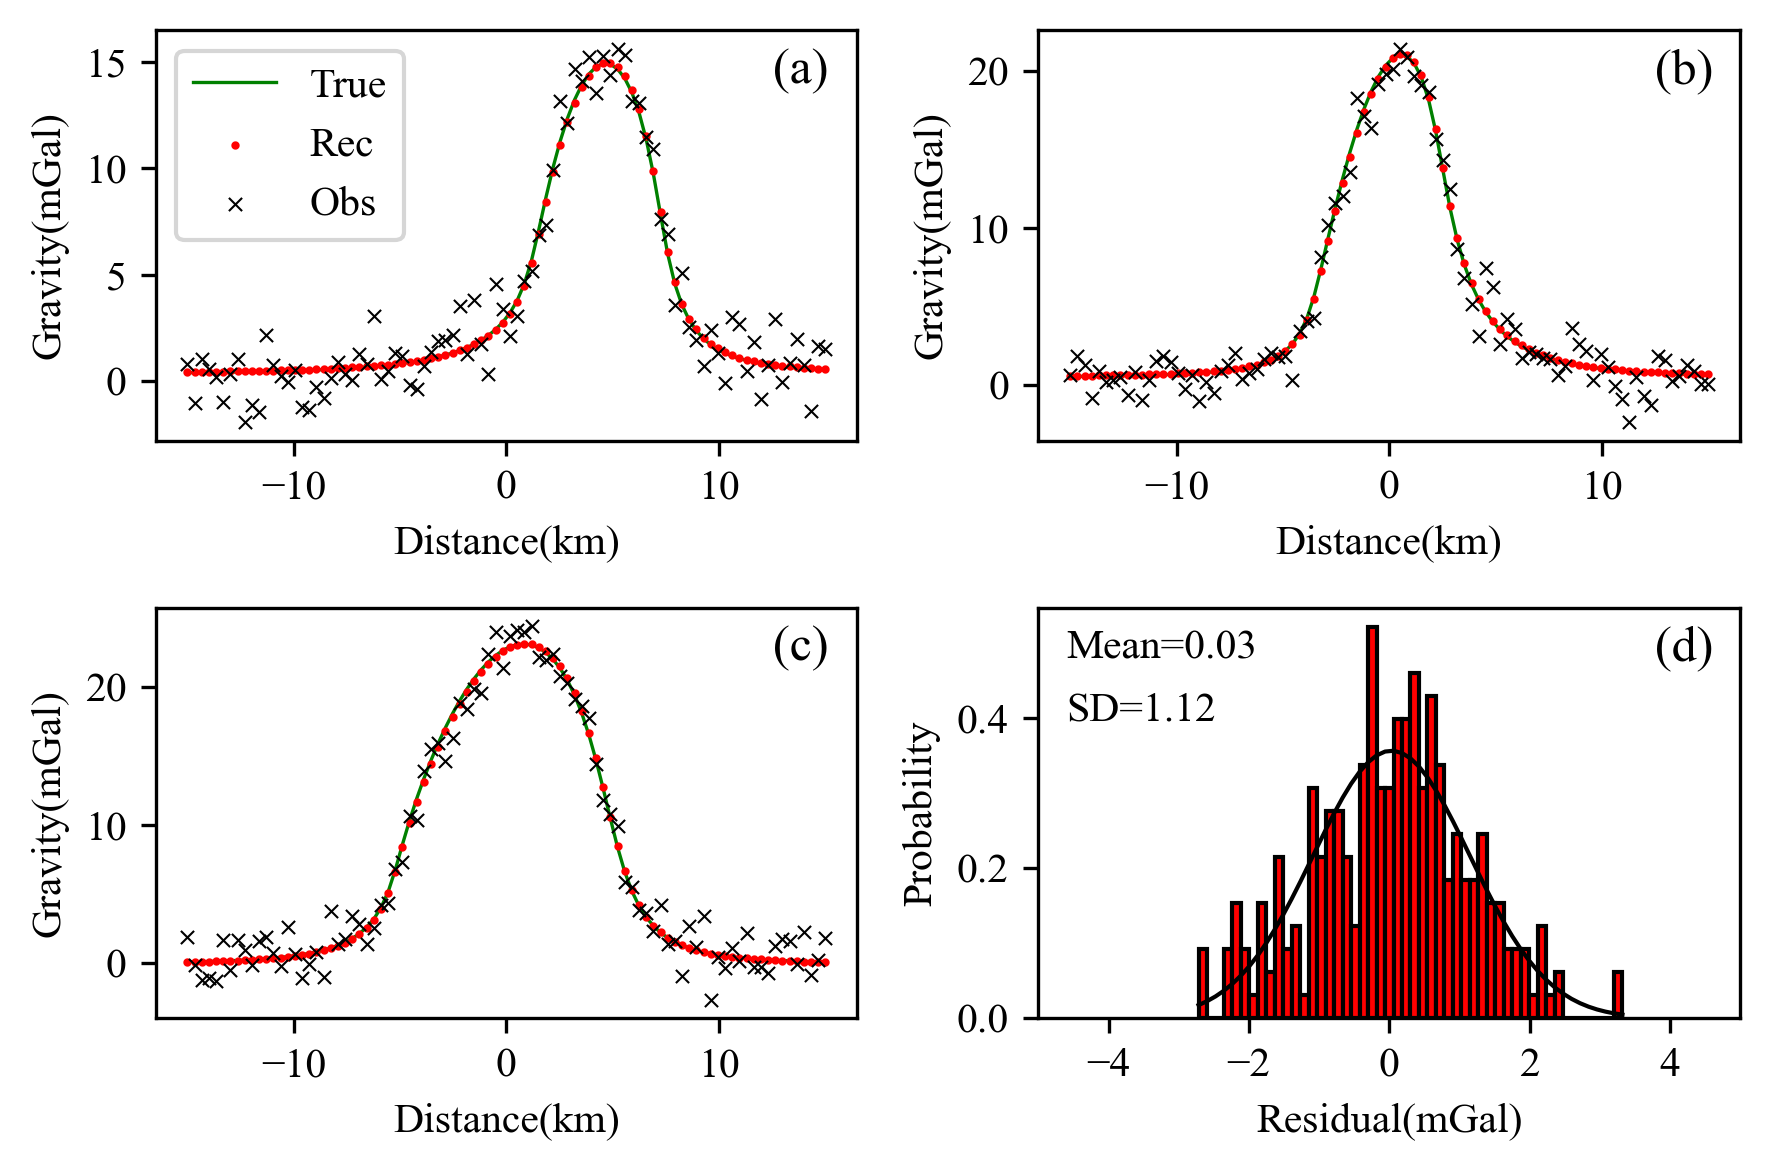

In [5]:
xline = np.linspace(-15, 15, num=90, endpoint=True)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize =(6,4), dpi = 300)

axs = axs.flatten()
axs[0].plot(xline, true_data[0:90], color = 'g', label = 'True', linewidth = 0.8, zorder=1)
axs[0].scatter(xline, gz_exp[0:90], s = 1, color = "r", label='Rec', zorder=2)
axs[0].scatter(xline, obs_data[0:90], s = 10, color = 'k', marker = 'x', linewidth = 0.5, label = 'Obs', zorder=2)
axs[0].set_xlabel("Distance(km)")
axs[0].set_ylabel("Gravity(mGal)")
axs[0].text(0.92, 0.9, "(a)", horizontalalignment='center', fontsize=12,
     verticalalignment='center', transform=axs[0].transAxes)
axs[0].legend()
#axs[0].text( 0.1, 0.1, "(a)", transform = ax.transAxes)

axs[1].plot(xline, true_data[90:180], color = 'g', label = 'True', linewidth = 0.8, zorder=1)
axs[1].scatter(xline, gz_exp[90:180], s = 1, color = "r", zorder=2)
axs[1].scatter(xline, obs_data[90:180], s = 10, color = "k", marker = 'x', linewidth = 0.5, zorder=2)
axs[1].set_xlabel("Distance(km)")
axs[1].set_ylabel("Gravity(mGal)")
axs[1].text(0.92, 0.9, "(b)", horizontalalignment='center', fontsize=12,
     verticalalignment='center', transform=axs[1].transAxes)

axs[2].plot(xline, true_data[180:270], color = 'g', label = 'True', linewidth = 0.8, zorder=1)
axs[2].scatter(xline, gz_exp[180:270], s = 1, color = "r", zorder=2)
axs[2].scatter(xline, obs_data[180:270], s = 10, color = "k", marker = 'x', linewidth = 0.5, zorder=2)
axs[2].set_xlabel("Distance(km)")
axs[2].set_ylabel("Gravity(mGal)")
axs[2].text(0.92, 0.9, "(c)", horizontalalignment='center', fontsize=12,
     verticalalignment='center', transform=axs[2].transAxes)

# Histogram 
ress = np.array(gz_exp[0:270]-obs_data)
mu = np.mean(ress)
sigma = np.std(ress, ddof = 1 )

n, bins, patches = axs[3].hist(ress, 50, density=True, color = "red", edgecolor='black')
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
axs[3].plot(bins, y, color = "black", linewidth = "1")
axs[3].set_xlabel("Residual(mGal)")
axs[3].set_ylabel("Probability")
axs[3].set_xlim(-5, 5)
axs[3].text(0.92, 0.9, "(d)", horizontalalignment='center', fontsize=12,
     verticalalignment='center', transform=axs[3].transAxes)
axs[3].text(0.04, 0.9, "Mean={}".format(0.03), horizontalalignment='left', fontsize=10,
     verticalalignment='center', transform=axs[3].transAxes)
axs[3].text(0.04, 0.75, "SD={}".format(1.12), horizontalalignment='left', fontsize=10,
     verticalalignment='center', transform=axs[3].transAxes)

fig.tight_layout()
plt.savefig("gravity_contrast_1.png",)
plt.savefig("gravity_contrast_1.pdf")
plt.show()

In [6]:
nx = 90
ny = 90
narea = tuple([-15, 15, -15, 15])
nshape = tuple([nx, ny])
outfile = f3.fault3d.fault(inp_file, log_file, nx, ny)
xp, yp, zp = gridder.regular(narea, nshape, z=0)

xp = np.array(xp)
yp = np.array(yp)
data = np.array(outfile).flatten()
from geoist.pfm import giutils
v = {
        'x' : list(yp),
        'y' : list(xp),
        'data' : data,}

x = xp.reshape(nx, ny)
y = yp.reshape(nx, ny)
da = data.reshape(nx, ny)

true_data = np.concatenate((da[:, 30],da[:, 55],da[50,:]))

field = giutils.contaminate(np.array(data), 0.10, percent = True, seed = 2022)
field = field.reshape(nx, ny)
obs_data = np.concatenate((field[:, 30],field[:, 55],field[50,:]))

def make_datafile(v, depth_bottom, dip, filename = 'f3d.dat'):
    with open(filename,'w') as f:
        f.write('1, 0\n')
        f.write('0.0, 0.0\n')
        f.write(str(v)+','+' 0.5,'+str(depth_bottom)+", 3.0")
        f.write(',6.0,L,')
        f.write(str(dip))
        f.write(',60,GL1,1.5,0.0\n')
        
def get_gravity(density_inv, depth_bottom, dip):
    make_datafile(density_inv, depth_bottom, dip)
    outfile = f3.fault3d.fault("f3d.inp", log_file, nx, ny)
    data = np.array(outfile).flatten()
    da = data.reshape(nx, ny)
    predict_data = np.concatenate((da[:, 30],da[:, 55],da[50, :]))
    os.remove("f3d.dat")
    return predict_data

gz_exp = get_gravity(0.519, 2.534, 152.860)

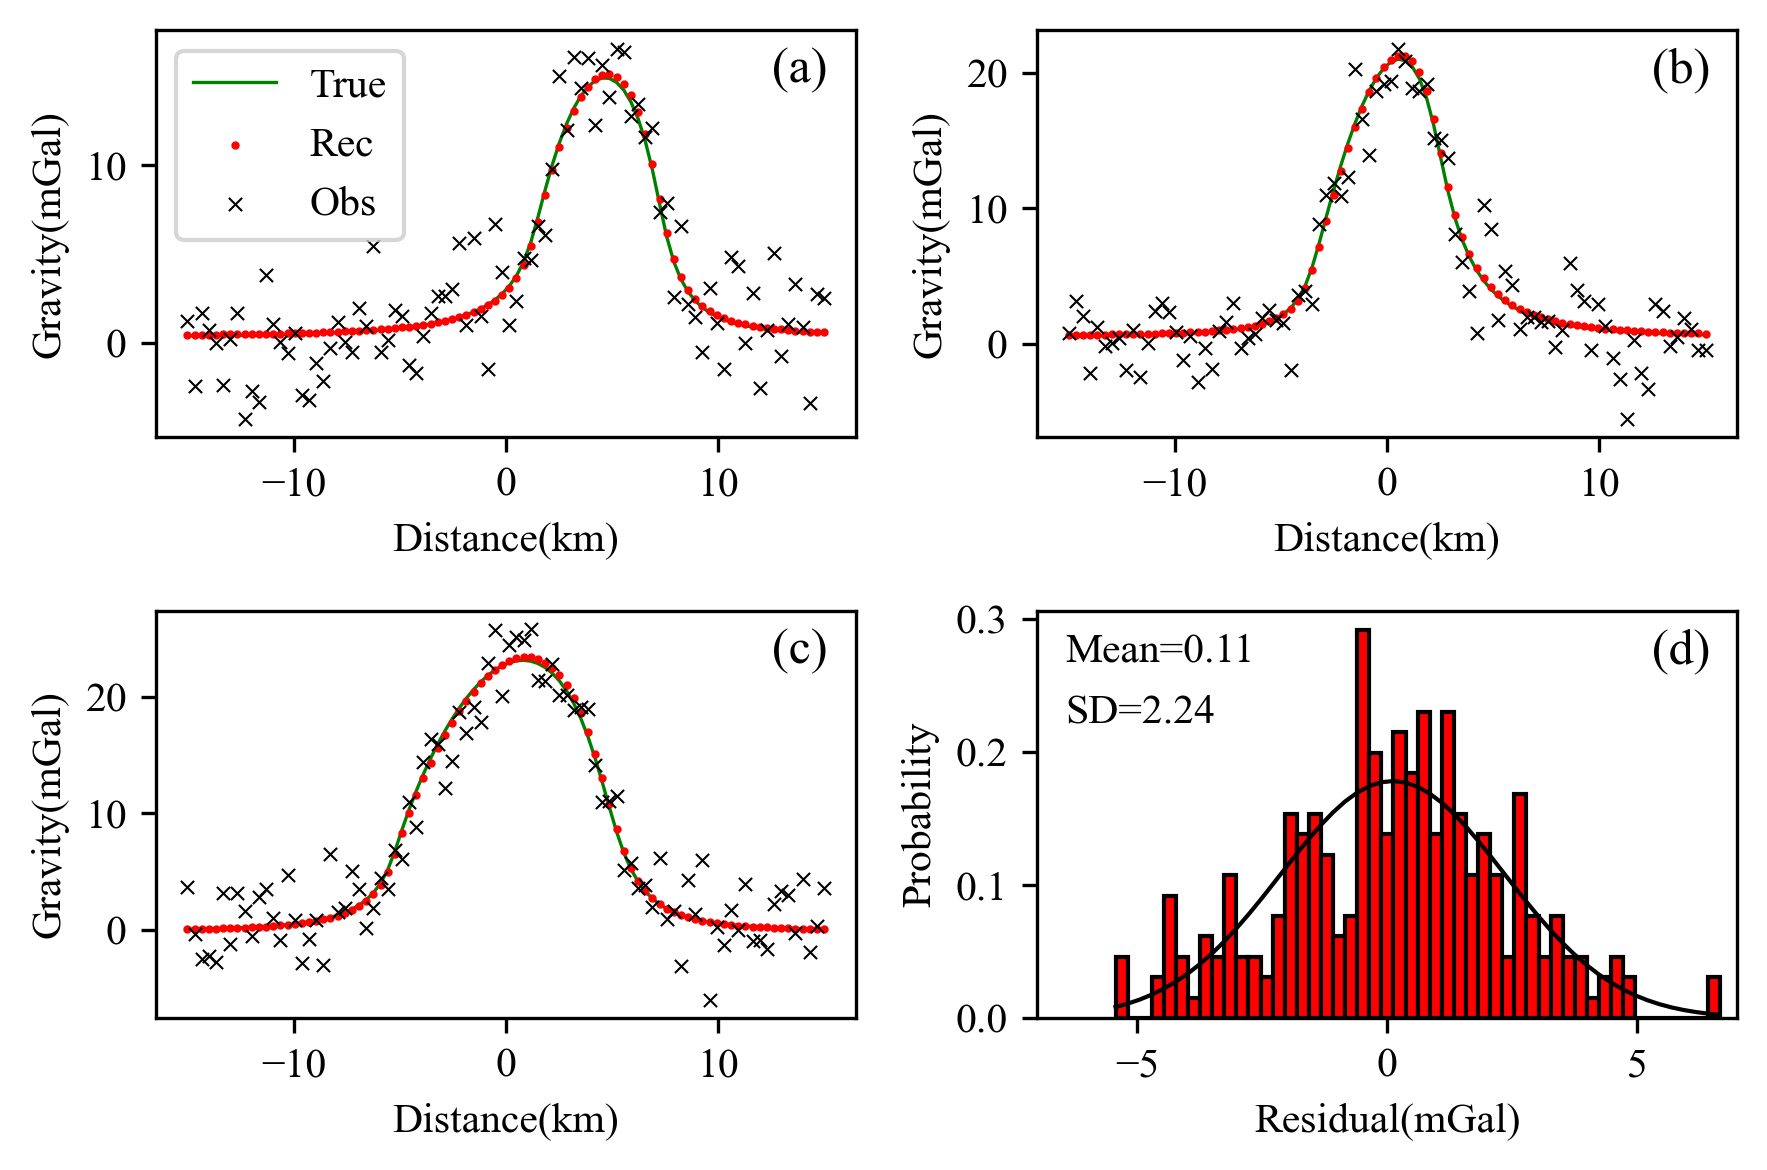

In [7]:
xline = np.linspace(-15, 15, num=90, endpoint=True)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize =(6,4), dpi = 300)

axs = axs.flatten()
axs[0].plot(xline, true_data[0:90], color = 'g', label = 'True', linewidth = 0.8, zorder=1)
axs[0].scatter(xline, gz_exp[0:90], s = 1, color = "r", label='Rec', zorder=2)
axs[0].scatter(xline, obs_data[0:90], s = 10, color = 'k', marker = 'x', linewidth = 0.5, label = 'Obs', zorder=2)
axs[0].set_xlabel("Distance(km)")
axs[0].set_ylabel("Gravity(mGal)")
axs[0].text(0.92, 0.9, "(a)", horizontalalignment='center', fontsize=12,
     verticalalignment='center', transform=axs[0].transAxes)
axs[0].legend()
#axs[0].text( 0.1, 0.1, "(a)", transform = ax.transAxes)

axs[1].plot(xline, true_data[90:180], color = 'g', label = 'True', linewidth = 0.8, zorder=1)
axs[1].scatter(xline, gz_exp[90:180], s = 1, color = "r", zorder=2)
axs[1].scatter(xline, obs_data[90:180], s = 10, color = "k", marker = 'x', linewidth = 0.5, zorder=2)
axs[1].set_xlabel("Distance(km)")
axs[1].set_ylabel("Gravity(mGal)")
axs[1].text(0.92, 0.9, "(b)", horizontalalignment='center', fontsize=12,
     verticalalignment='center', transform=axs[1].transAxes)

axs[2].plot(xline, true_data[180:270], color = 'g', label = 'True', linewidth = 0.8, zorder=1)
axs[2].scatter(xline, gz_exp[180:270], s = 1, color = "r", zorder=2)
axs[2].scatter(xline, obs_data[180:270], s = 10, color = "k", marker = 'x', linewidth = 0.5, zorder=2)
axs[2].set_xlabel("Distance(km)")
axs[2].set_ylabel("Gravity(mGal)")
axs[2].text(0.92, 0.9, "(c)", horizontalalignment='center', fontsize=12,
     verticalalignment='center', transform=axs[2].transAxes)

# Histogram 
ress = np.array(gz_exp[0:270]-obs_data)
mu = np.mean(ress)
sigma = np.std(ress, ddof = 1 )

n, bins, patches = axs[3].hist(ress, 50, density=True, color = "red", edgecolor='black')
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
axs[3].plot(bins, y, color = "black", linewidth = "1")
axs[3].set_xlabel("Residual(mGal)")
axs[3].set_ylabel("Probability")
axs[3].set_xlim(-7, 7)
axs[3].text(0.92, 0.9, "(d)", horizontalalignment='center', fontsize=12,
     verticalalignment='center', transform=axs[3].transAxes)
axs[3].text(0.04, 0.9, "Mean={}".format(0.11), horizontalalignment='left', fontsize=10,
     verticalalignment='center', transform=axs[3].transAxes)
axs[3].text(0.04, 0.75, "SD={}".format(2.24), horizontalalignment='left', fontsize=10,
     verticalalignment='center', transform=axs[3].transAxes)

fig.tight_layout()
plt.savefig("gravity_contrast_2.png",)
plt.savefig("gravity_contrast_2.pdf")
plt.show()

In [8]:
import matplotlib
matplotlib.get_cachedir()

'/public/home/liyongbo/.cache/matplotlib'